In [1]:
import pandas as pd
import os
import pytz

In [2]:
import numpy as np
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 실제 TTF 파일 경로 (예: 나눔고딕)
font_path = '/content/drive/MyDrive/NanumFontSetup_TTF_ALL/NanumGothic.ttf'

# 폰트 등록 및 적용
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

In [3]:
top_multi_df = pd.read_parquet('/content/drive/MyDrive/data/multi_buyers_all_events.parquet')

### 카테고리 3 결측치 처리

In [4]:
# category_lvl3가 결측치인 경우 category_lvl2로 대체
top_multi_df['category_lvl3'] = top_multi_df['category_lvl3'].fillna(top_multi_df['category_lvl2'])

# 분석 목표:
고객 재구매 유도 통한 고객 리텐션 향상

데이터 분석 목표: 1회 구매자 vs 2회 이상 구매자 나누어 분석 후, 재구매 요인 분석과 재구매 유도 방안 도출 (재구매하는 안 하는 이유와 재구매하는 이유 분석)

# 카테고리 레벨3별 전환 퍼널 분석(전환율)

In [ ]:
# 1. 이벤트별 필터링
views = top_multi_df[top_multi_df['event_type'] == 'view']
carts = top_multi_df[top_multi_df['event_type'] == 'cart']
purchases = top_multi_df[top_multi_df['event_type'] == 'purchase']

# 2. 상품별 이벤트 수 집계
view_counts = views.groupby('product_id').size().reset_index(name='view_count')
cart_counts = carts.groupby('product_id').size().reset_index(name='cart_count')
purchase_counts = purchases.groupby('product_id').size().reset_index(name='purchase_count')

# 3. 병합
product_stats = view_counts.merge(cart_counts, on='product_id', how='outer')
product_stats = product_stats.merge(purchase_counts, on='product_id', how='outer')
product_stats.fillna(0, inplace=True)

# 4. 퍼널 전환율 계산
product_stats['view_to_cart_rate'] = product_stats['cart_count'] / product_stats['view_count']
product_stats['cart_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['cart_count']
product_stats['view_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['view_count']

# 5. 상품 정보 결합 (선택)
product_stats = pd.merge(
    product_stats,
    top_multi_df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates(),
    on='product_id', how='left'
)

# 6. 결과 확인 (view 수 기준으로 필터링하여 너무 적은 데이터 제거 가능)
product_stats_filtered = product_stats[product_stats['view_count'] >= 30]
print(product_stats_filtered[['product_id', 'category_lvl3', 'view_to_cart_rate', 'cart_to_purchase_rate', 'view_to_purchase_rate']].sort_values(by='view_to_purchase_rate', ascending=False).head(10))

       product_id    category_lvl3  view_to_cart_rate  cart_to_purchase_rate  \
56853    24601808             pump           0.571429               0.714286   
60439    26203808           faucet           0.212121               1.428571   
44867    20200030           kettle           0.284753               1.047244   
23743     6701232       air_heater           0.241758               1.227273   
14381     4200774  air_conditioner           0.628571               0.454545   
56089    24600504          welding           0.388889               0.714286   
3592      1701206         massager           0.340659               0.806452   
14833     4201541  air_conditioner           0.299394               0.902834   
45033    21100410             pump           0.261905               1.000000   
10299     2800681    refrigerators           0.290323               0.888889   

       view_to_purchase_rate  
56853               0.408163  
60439               0.303030  
44867               0.2982

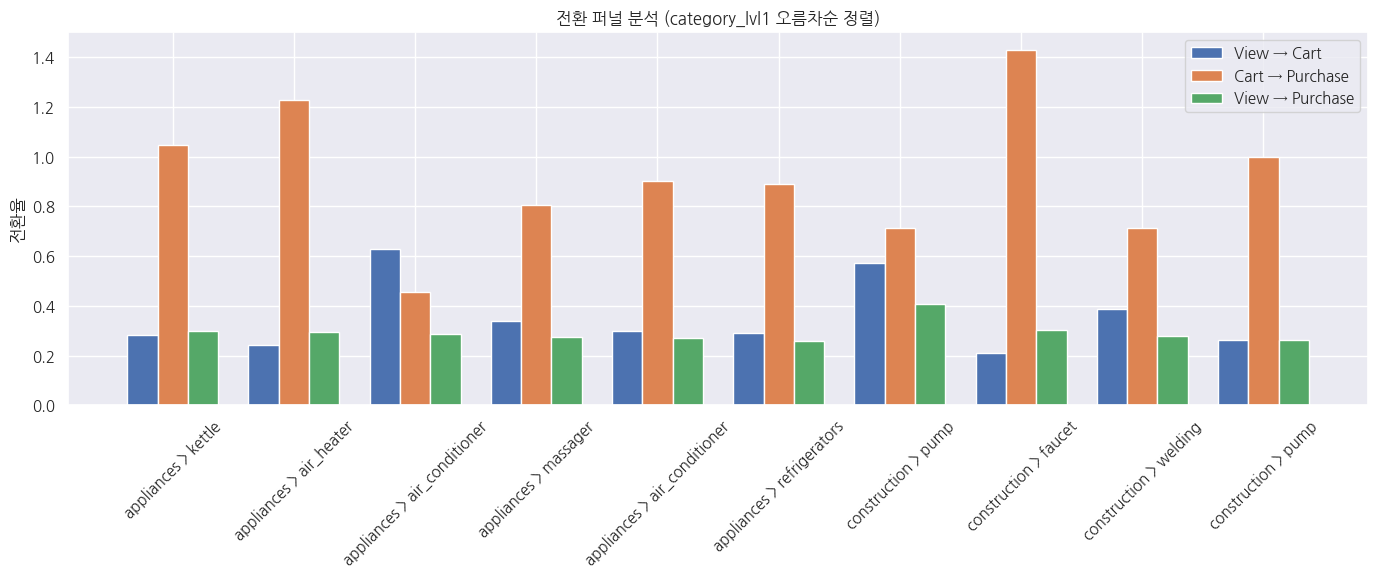

In [ ]:
top_funnel = product_stats_filtered.sort_values(by='view_to_purchase_rate', ascending=False).head(10)

# 1. 새로운 라벨 컬럼 생성
top_funnel['category_label'] = top_funnel['category_lvl1'] + ' > ' + top_funnel['category_lvl3']

# 2. category_lvl1 기준 오름차순 정렬
top_funnel_sorted = top_funnel.sort_values(by='category_lvl1')

# 3. 시각화
plt.figure(figsize=(14, 6))
bar_width = 0.25
x = range(len(top_funnel_sorted))

plt.bar(x, top_funnel_sorted['view_to_cart_rate'], width=bar_width, label='View → Cart')
plt.bar([p + bar_width for p in x], top_funnel_sorted['cart_to_purchase_rate'], width=bar_width, label='Cart → Purchase')
plt.bar([p + bar_width*2 for p in x], top_funnel_sorted['view_to_purchase_rate'], width=bar_width, label='View → Purchase')

# 정렬된 라벨 적용
plt.xticks([p + bar_width for p in x], top_funnel_sorted['category_label'], rotation=45)
plt.ylabel('전환율')
plt.title('전환 퍼널 분석 (category_lvl1 오름차순 정렬)')
plt.legend()
plt.tight_layout()
plt.show()

# 가격 구간별 구매율

In [ ]:
# 1. 가격 구간 나누기 (10만원 단위, 필요시 조정 가능)
# 올바른 bins와 labels 정의
bins = [0, 100, 200, 300, 400, 500, 1000, float('inf')]  # 8개 → 7개 구간
labels = ['0~100', '100~200', '200~300', '300~400', '400~500', '500~1000', '1000+']  # 7개

# 가격 구간 생성
top_multi_df['price_bin'] = pd.cut(top_multi_df['price'], bins=bins, labels=labels, right=False)


# 2. 구매, 조회 이벤트만 나누기
purchase_df = top_multi_df[top_multi_df['event_type'] == 'purchase']
view_df = top_multi_df[top_multi_df['event_type'] == 'view']

# 3. 가격 구간별 이벤트 수 집계
purchase_stats = purchase_df['price_bin'].value_counts().sort_index().reset_index()
purchase_stats.columns = ['price_bin', 'purchase_count']

view_stats = view_df['price_bin'].value_counts().sort_index().reset_index()
view_stats.columns = ['price_bin', 'view_count']

# 4. 병합 및 구매율 계산
price_group_stats = pd.merge(purchase_stats, view_stats, on='price_bin', how='outer')

# 숫자 컬럼만 골라서 NaN을 0으로 대체
numeric_cols = ['purchase_count', 'view_count']
price_group_stats[numeric_cols] = price_group_stats[numeric_cols].fillna(0)

# 구매율 계산
price_group_stats['conversion_rate'] = price_group_stats['purchase_count'] / price_group_stats['view_count']

# 결과 확인
print(price_group_stats)

  price_bin  purchase_count  view_count  conversion_rate
0     0~100          402950     9157180         0.044004
1   100~200          986327    11177389         0.088243
2   200~300          610408     7245904         0.084242
3   300~400          268533     3922403         0.068461
4   400~500          204417     2651407         0.077098
5  500~1000          640843     7276868         0.088066
6     1000+          246056     2975554         0.082693


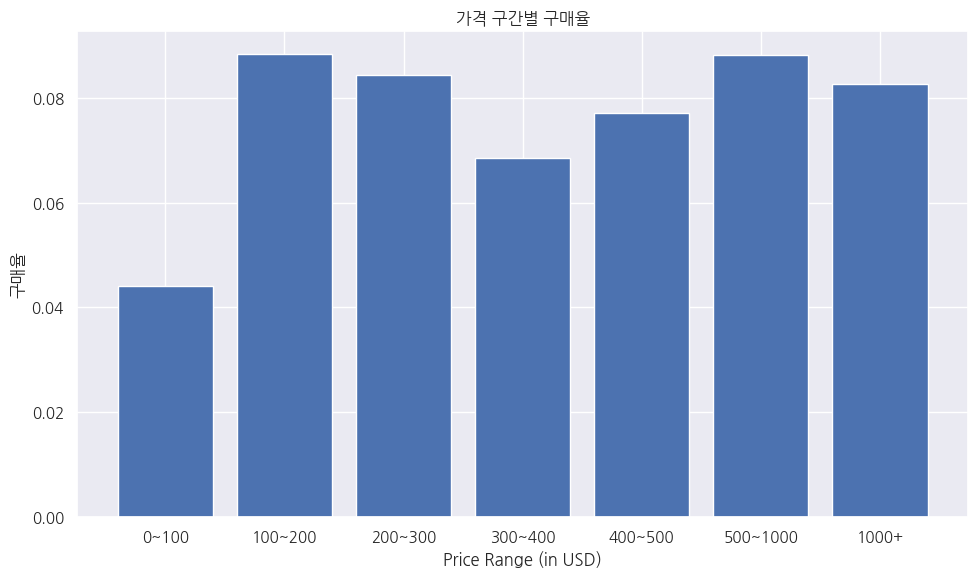

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(price_group_stats['price_bin'].astype(str), price_group_stats['conversion_rate'])
plt.title('가격 구간별 구매율')
plt.xlabel('Price Range (in USD)')
plt.ylabel('구매율')
plt.tight_layout()
plt.show()

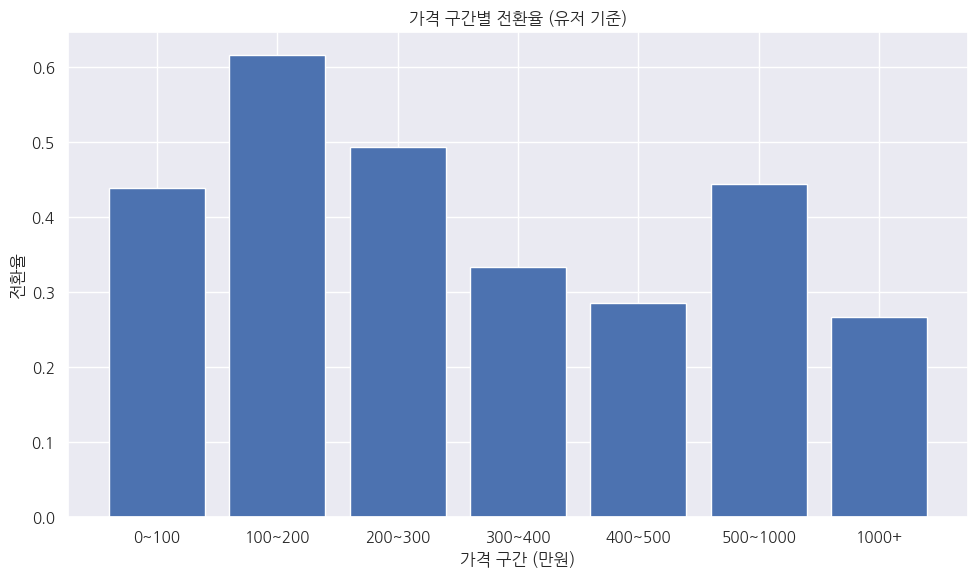

In [7]:
# 1. 가격 구간 정의
bins = [0, 100, 200, 300, 400, 500, 1000, float('inf')]
labels = ['0~100', '100~200', '200~300', '300~400', '400~500', '500~1000', '1000+']
top_multi_df['price_bin'] = pd.cut(top_multi_df['price'], bins=bins, labels=labels, right=False)

# 2. 유저 단위 중복 제거
view_df = top_multi_df[top_multi_df['event_type'] == 'view'][['user_id', 'product_id', 'price_bin']].drop_duplicates()
purchase_df = top_multi_df[top_multi_df['event_type'] == 'purchase'][['user_id', 'product_id', 'price_bin']].drop_duplicates()

# 3. 가격 구간별 유저 수 집계 (FutureWarning 방지 위해 observed=True 추가)
view_stats = view_df.groupby('price_bin', observed=True)['user_id'].nunique().reset_index()
view_stats.columns = ['price_bin', 'view_user_count']

purchase_stats = purchase_df.groupby('price_bin', observed=True)['user_id'].nunique().reset_index()
purchase_stats.columns = ['price_bin', 'purchase_user_count']

# 4. 병합 및 전환율 계산
price_group_stats = pd.merge(view_stats, purchase_stats, on='price_bin', how='outer')

# ➤ 숫자 컬럼만 fillna(0)
price_group_stats['view_user_count'] = price_group_stats['view_user_count'].fillna(0)
price_group_stats['purchase_user_count'] = price_group_stats['purchase_user_count'].fillna(0)

price_group_stats['conversion_rate'] = price_group_stats['purchase_user_count'] / price_group_stats['view_user_count']
price_group_stats = price_group_stats.sort_values(by='price_bin')

# 5. 시각화
plt.figure(figsize=(10, 6))
plt.bar(price_group_stats['price_bin'].astype(str), price_group_stats['conversion_rate'])
plt.title('가격 구간별 전환율 (유저 기준)')
plt.xlabel('가격 구간 (만원)')
plt.ylabel('전환율')
plt.tight_layout()
plt.show()

# 고객 유형 별 레벨 3 상품 구매 건수
다양한 상품 구매 고객 vs 같은 상품 반복 고객 구분
→ 고객 타입별 리텐션 전략 차별화

제품군이 다양한 고객 vs 집중된 고객 비교
→ 어떤 그룹이 재구매 가능성 높은지 파악

In [ ]:
# 구매 데이터만 필터링
purchase_df = top_multi_df[top_multi_df['event_type'] == 'purchase']

# 고객별 총 구매 수
user_total_purchases = purchase_df.groupby('user_id')['product_id'].count().reset_index(name='total_purchases')

# 고객별 고유한 product_id 수
user_unique_products = purchase_df.groupby('user_id')['product_id'].nunique().reset_index(name='unique_products')

# 병합
user_profile = pd.merge(user_total_purchases, user_unique_products, on='user_id')

# 고객 유형 분류
def classify_user(row):
    if row['unique_products'] == 1:
        return 'same_product_repeated'
    else:
        return 'various_products'

user_profile['user_type'] = user_profile.apply(classify_user, axis=1)

# 결과 확인
print(user_profile['user_type'].value_counts())

user_type
various_products         505662
same_product_repeated    139536
Name: count, dtype: int64


In [ ]:
# user_type 정보 결합
purchase_df = purchase_df.merge(user_profile[['user_id', 'user_type']], on='user_id', how='left')

# 사용자 유형 + 카테고리 기준으로 집계
user_type_cat = purchase_df.groupby(['user_type', 'category_lvl3']).size().reset_index(name='purchase_count')

# 상위 10개씩 확인
print(user_type_cat.sort_values(by='purchase_count', ascending=False).groupby('user_type').head(10))


                 user_type   category_lvl3  purchase_count
77        various_products           light         1482437
94        various_products      smartphone          535072
23   same_product_repeated           light          183637
59        various_products          clocks          127892
70        various_products       headphone          122054
78        various_products        massager          109580
89        various_products   refrigerators           82549
104       various_products          washer           72903
102       various_products          vacuum           69646
40   same_product_repeated      smartphone           57136
101       various_products              tv           50989
60        various_products  coffee_grinder           35422
16   same_product_repeated       headphone           15944
5    same_product_repeated          clocks           14074
24   same_product_repeated        massager           12367
48   same_product_repeated          vacuum            97

/tmp/ipython-input-2181019986.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_cats = user_type_cat.groupby('user_type').apply(lambda x: x.sort_values(by='purchase_count', ascending=False).head(10)).reset_index(drop=True)


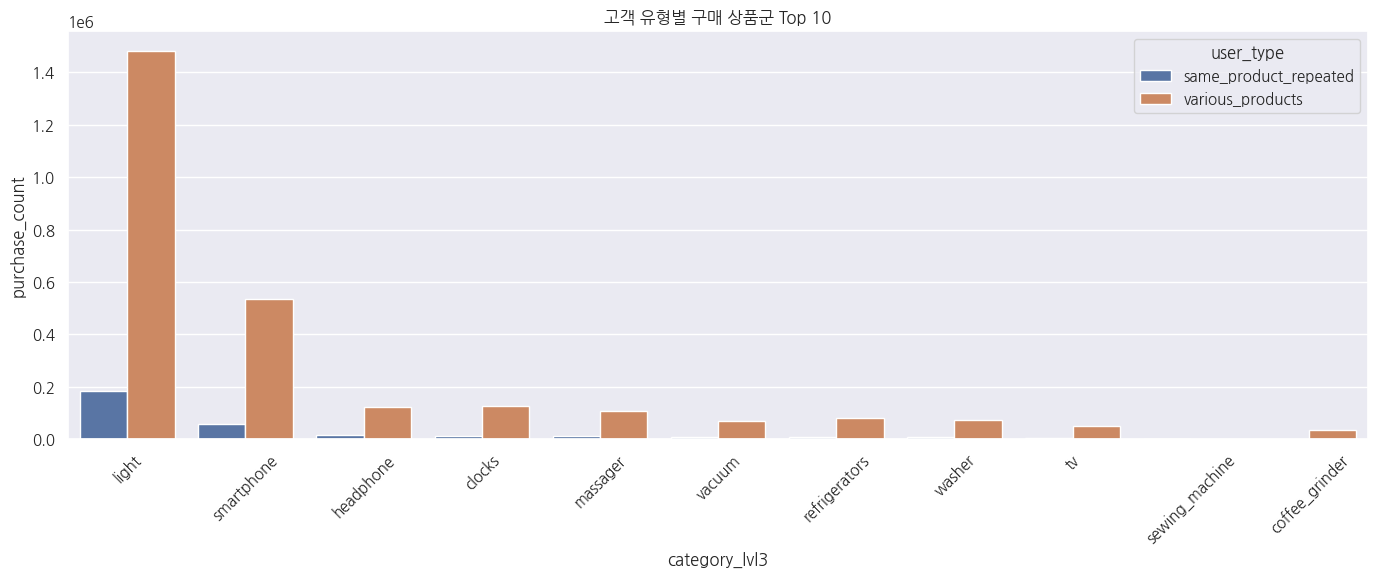

In [ ]:
# 상위 10개만 시각화
top_cats = user_type_cat.groupby('user_type').apply(lambda x: x.sort_values(by='purchase_count', ascending=False).head(10)).reset_index(drop=True)

plt.figure(figsize=(14, 6))
sns.barplot(data=top_cats, x='category_lvl3', y='purchase_count', hue='user_type')
plt.title('고객 유형별 구매 상품군 Top 10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


| 고객유형                    | 반복 구매한 상품군  | 전략 제안                    |
| ----------------------- | ----------- | ------------------------ |
| same\_product\_repeated | 소모품/생활필수품 등 | 재구매 유도, 리마인드 캠페인, 구독 서비스 |
| various\_products       | 카테고리 다양함    | 추천 상품 시스템, 유사 상품 큐레이션    |


# 고객 수익성 상위 카테고리3

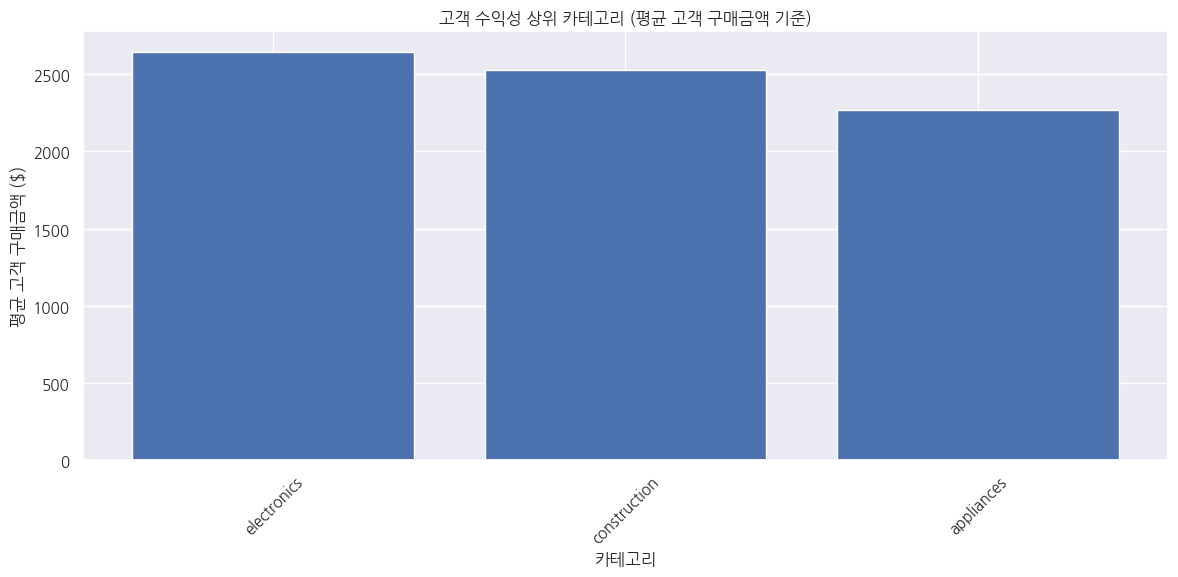

In [ ]:
# 유저별 전체 구매금액
user_value = purchase_df.groupby('user_id')['price'].sum().reset_index()
user_value.columns = ['user_id', 'total_spent']

# 카테고리별 평균 고객 구매금액 계산
avg_value_cat = purchase_df.groupby('category_lvl1')['user_id'].apply(
    lambda x: user_value[user_value['user_id'].isin(x)]['total_spent'].mean()
).reset_index(name='avg_user_value')

# 상위 카테고리 10개 시각화
top_value_cat = avg_value_cat.sort_values('avg_user_value', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_value_cat['category_lvl1'].astype(str), top_value_cat['avg_user_value'])
plt.title('고객 수익성 상위 카테고리 (평균 고객 구매금액 기준)')
plt.xlabel('카테고리')
plt.ylabel('평균 고객 구매금액 ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# 유저별 전체 구매금액
user_value = purchase_df.groupby('user_id')['price'].sum().reset_index()
user_value.columns = ['user_id', 'total_spent']

# 카테고리별 평균 고객 구매금액 계산
avg_value_cat = purchase_df.groupby('category_lvl2')['user_id'].apply(
    lambda x: user_value[user_value['user_id'].isin(x)]['total_spent'].mean()
).reset_index(name='avg_user_value')

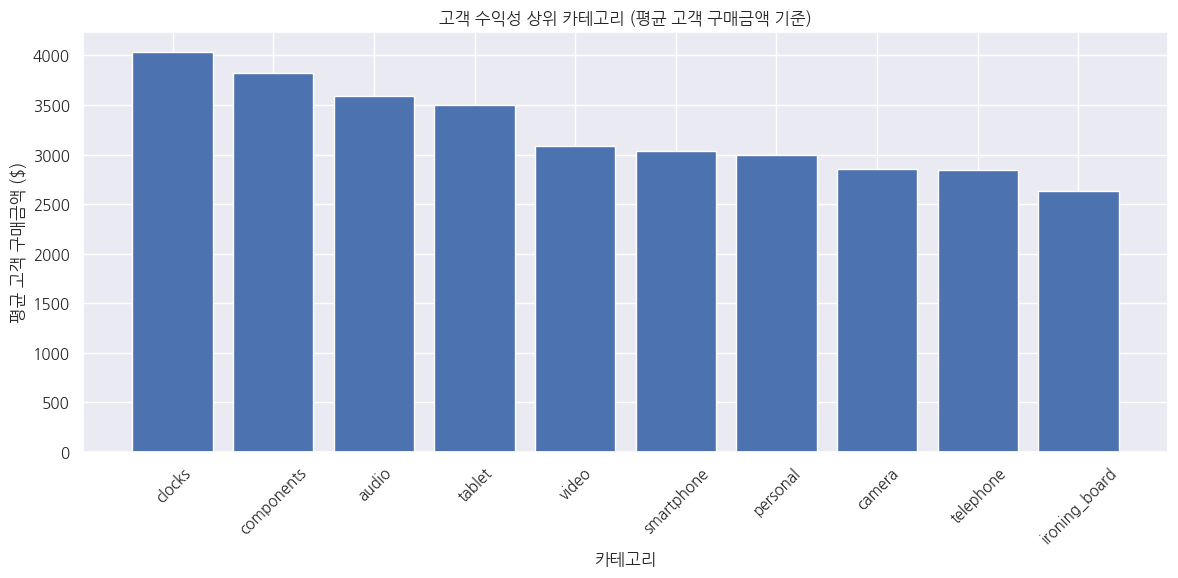

In [ ]:
# 상위 카테고리 10개 시각화
top_value_cat = avg_value_cat.sort_values('avg_user_value', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_value_cat['category_lvl2'].astype(str), top_value_cat['avg_user_value'])
plt.title('고객 수익성 상위 카테고리 (평균 고객 구매금액 기준)')
plt.xlabel('카테고리')
plt.ylabel('평균 고객 구매금액 ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

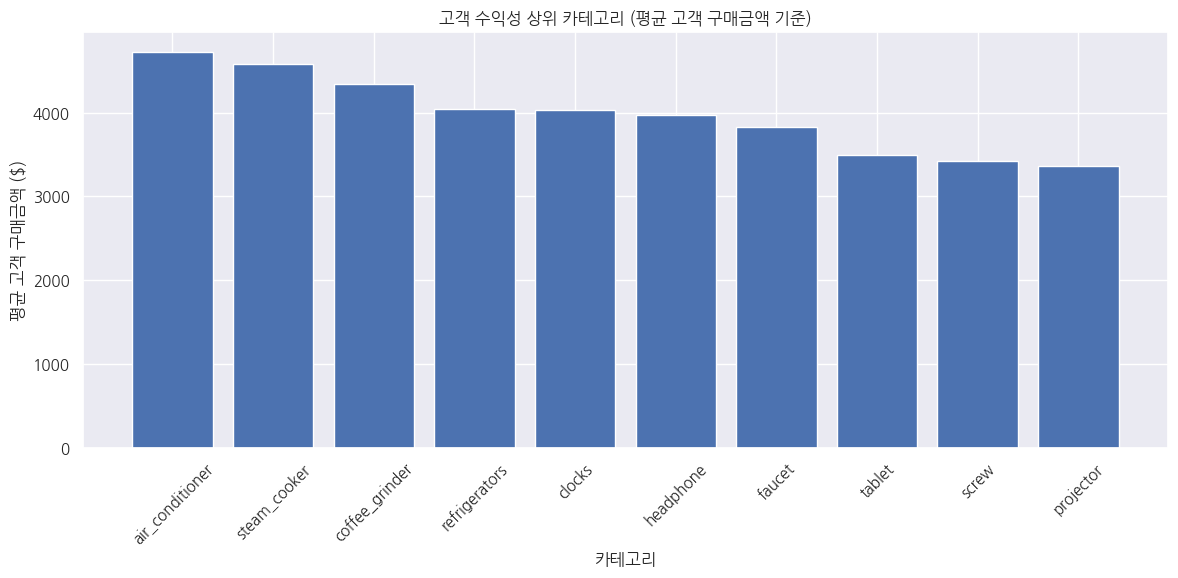

In [ ]:
# 유저별 전체 구매금액
user_value = purchase_df.groupby('user_id')['price'].sum().reset_index()
user_value.columns = ['user_id', 'total_spent']

# 카테고리별 평균 고객 구매금액 계산
avg_value_cat = purchase_df.groupby('category_lvl3')['user_id'].apply(
    lambda x: user_value[user_value['user_id'].isin(x)]['total_spent'].mean()
).reset_index(name='avg_user_value')

# 상위 카테고리 10개 시각화
top_value_cat = avg_value_cat.sort_values('avg_user_value', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_value_cat['category_lvl3'].astype(str), top_value_cat['avg_user_value'])
plt.title('고객 수익성 상위 카테고리 (평균 고객 구매금액 기준)')
plt.xlabel('카테고리')
plt.ylabel('평균 고객 구매금액 ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 카테고리 레벨2, 3별 매출 총합 순위

In [ ]:
# 1. 상품별 매출 계산 (price × 건수)
purchase_df = top_multi_df[top_multi_df['event_type'] == 'purchase']
product_revenue = purchase_df.groupby('product_id')['price'].sum().reset_index(name='total_revenue')

# 2. 상품 정보 붙이기 (카테고리 포함)
product_info = top_multi_df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates()
product_revenue = pd.merge(product_revenue, product_info, on='product_id', how='left')

# 3. 매출 총합 상위 10개 상품 출력
top_products = product_revenue.sort_values(by='total_revenue', ascending=False).head(10)
print(top_products)

      product_id  total_revenue category_lvl1 category_lvl2 category_lvl3
1667     1005115   1.160029e+08   electronics    smartphone    smartphone
1668     1005115   1.160029e+08  construction         tools         light
1647     1005105   6.972752e+07   electronics    smartphone    smartphone
1648     1005105   6.972752e+07  construction         tools         light
1707     1005135   3.852481e+07   electronics    smartphone    smartphone
1708     1005135   3.852481e+07  construction         tools         light
67       1002544   3.794599e+07   electronics    smartphone    smartphone
68       1002544   3.794599e+07  construction         tools         light
731      1004249   3.767327e+07  construction         tools         light
730      1004249   3.767327e+07   electronics    smartphone    smartphone


### 카테고리 레벨 2 매출 상위 10

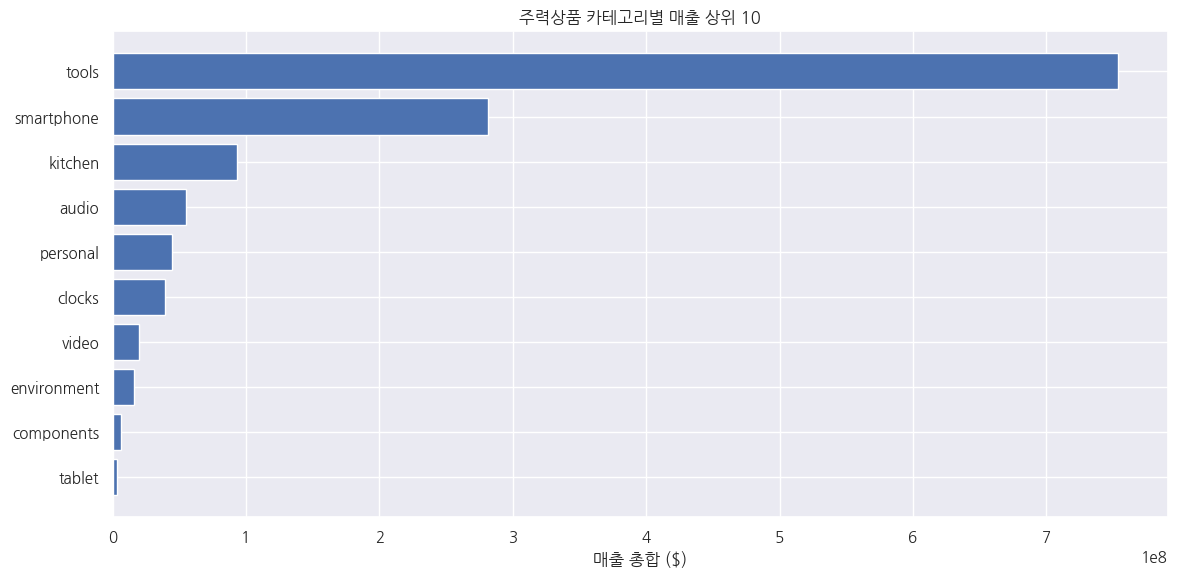

In [ ]:
# 4. 카테고리별 매출 총합 (category_lvl2 기준)
category_revenue = purchase_df.groupby('category_lvl2')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl2'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 카테고리 레벨 3 매출 상위 10

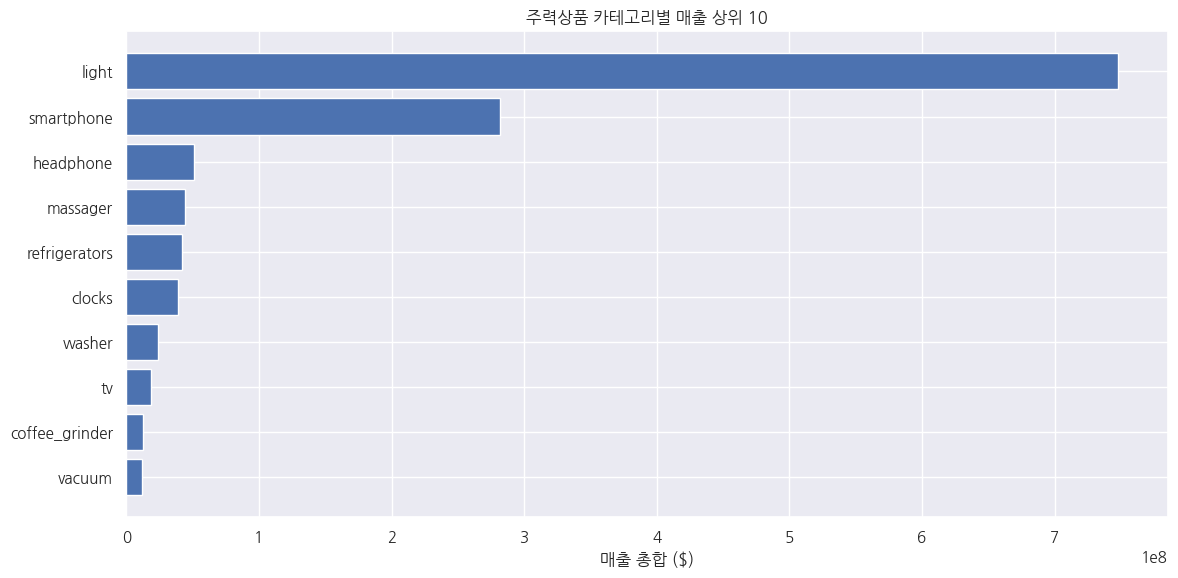

In [ ]:
# 4. 카테고리별 매출 총합 (category_lvl3 기준)
category_revenue = purchase_df.groupby('category_lvl3')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl3'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()